In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import tkinter as tk



In [2]:
from database.BuildingRepository import BuildingRepository
from modules import ACStatusAdapter
from datetime import datetime, timedelta
def get_iot_readings():
    building_repo = BuildingRepository()
    iots = building_repo.get_historic_iots(datetime.now() - timedelta(days=1))
    iot_readings_historic = pd.DataFrame(iots)
    iot_readings_historic = iot_readings_historic.drop("_id", axis=1)
    return iot_readings_historic
iot_readings_historic = get_iot_readings()
iot_readings_historic

,iots,datetime
0,"[{'name': 'Air Conditioner 101', 'type': 'hvac...",2024-04-22 15:20:29.174
1,"[{'name': 'Air Conditioner 101', 'type': 'hvac...",2024-04-22 15:20:24.356
2,"[{'name': 'Air Conditioner 101', 'type': 'hvac...",2024-04-22 15:20:19.409
3,"[{'name': 'Air Conditioner 101', 'type': 'hvac...",2024-04-22 15:20:14.247
4,"[{'name': 'Air Conditioner 101', 'type': 'hvac...",2024-04-22 15:20:09.303
...,...,...
17259,"[{'name': 'Air Conditioner 101', 'type': 'hvac...",2024-04-21 15:21:02.227
17260,"[{'name': 'Air Conditioner 101', 'type': 'hvac...",2024-04-21 15:20:57.378
17261,"[{'name': 'Air Conditioner 101', 'type': 'hvac...",2024-04-21 15:20:52.045
17262,"[{'name': 'Air Conditioner 101', 'type': 'hvac...",2024-04-21 15:20:47.379


In [ ]:
del iot_readings_historic

In [3]:
considered_iots = ["Lamp 1_103","Weather","Temperature Sensor 103","Humidity Sensor 103","Light Sensor 103","Air Conditioner 103"]
aux = pd.DataFrame()
for i, row in iot_readings_historic.iterrows():
    new = pd.DataFrame()
    for iot in row['iots']:
        if iot['name'] in considered_iots:
            for value in iot['values']:
                val = value['values']
                new[iot['name'] + '_' + value['type']] = [val]

    aux = pd.concat([aux, new])

aux.rename(
    columns={"Weather" + "_temperature": 'Outside temperature (ºC)',
               "Temperature Sensor 103" + "_temperature": 'Temperature (Cº)',
                "Humidity Sensor 103" + "_humidity": 'Humidity (%)',
                "Light Sensor 103" + "_light": 'Light (%)',
                "Lamp 1_103_power": 'Lamp 1'},
    inplace=True)
val = aux.values.tolist()
aux = pd.DataFrame(val,columns=['Air Conditioner_power','Air Conditioner_voltage','Air Conditioner_current','Lamp 1','Temperature (Cº)','Humidity (%)','Light (%)','Outside temperature (ºC)'])
aux

,Air Conditioner_power,Air Conditioner_voltage,Air Conditioner_current,Lamp 1,Temperature (Cº),Humidity (%),Light (%),Outside temperature (ºC)
0,20.0,228.0,3.0,0.0,261.0,404.0,676.0,22.8
1,20.0,228.0,3.0,0.0,261.0,404.0,676.0,22.8
2,20.0,228.0,3.0,0.0,261.0,404.0,676.0,22.8
3,20.0,228.0,3.0,0.0,261.0,404.0,676.0,22.8
4,20.0,230.0,3.0,0.0,261.0,404.0,676.0,22.8
...,...,...,...,...,...,...,...,...
17259,0.0,236.0,2.0,0.0,203.0,436.0,104.0,25.6
17260,0.0,237.0,2.0,0.0,203.0,435.0,104.0,25.6
17261,0.0,239.0,2.0,0.0,203.0,435.0,104.0,25.6
17262,0.0,238.0,2.0,0.0,203.0,435.0,104.0,25.6


In [5]:
df = aux
df['AC status'] = df.apply(lambda x: 0 if x['Air Conditioner_power'] == 0 else 1, axis=1)
df['Outside temperature (ºC)'] = df.apply(lambda x: x['Outside temperature (ºC)']*10, axis=1)
df['Occupation'] = df.apply(lambda x: 0 if x['Light (%)'] < 500 else 1, axis=1)
df = df.drop(["Air Conditioner_power","Air Conditioner_voltage","Air Conditioner_current","Lamp 1"], axis=1)
df['Heat Index (ºC)'] = ACStatusAdapter.calculate_heat_index_custom_celsius(df['Temperature (Cº)'], df['Humidity (%)'])
df

,Temperature (Cº),Humidity (%),Light (%),Outside temperature (ºC),AC status,Occupation,Heat Index (ºC)
0,261.0,404.0,676.0,2280.0,1,1,114051.526287
1,261.0,404.0,676.0,2280.0,1,1,114051.526287
2,261.0,404.0,676.0,2280.0,1,1,114051.526287
3,261.0,404.0,676.0,2280.0,1,1,114051.526287
4,261.0,404.0,676.0,2280.0,1,1,114051.526287
...,...,...,...,...,...,...,...
17259,203.0,436.0,104.0,2560.0,0,0,80587.368563
17260,203.0,435.0,104.0,2560.0,0,0,80280.968378
17261,203.0,435.0,104.0,2560.0,0,0,80280.968378
17262,203.0,435.0,104.0,2560.0,0,0,80280.968378


In [ ]:
#Oversampling 
X = df[['Outside temperature (ºC)', 'Temperature (Cº)', 'Humidity (%)', 'Heat Index (ºC)', 'Occupation']]
y = df['AC status']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Tamanho base de dados após oversampling:", len(X_resampled))
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.19, random_state=42)
#Grid Search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(X_resampled, y_resampled)

print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor pontuação de validação cruzada:", grid_search.best_score_)

Tamanho base de dados após oversampling: 29738
Melhores hiperparâmetros: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Melhor pontuação de validação cruzada: 0.8709025160493573


In [ ]:
best_clf = grid_search.best_estimator_

#Treinar o modelo
best_clf.fit(X_resampled, y_resampled)

#Avaliação do modelo
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy * 100:.5f}%')

Acurácia do modelo: 99.59299%


In [ ]:
y_pred

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
import pickle

# Save the model to a file
model_filename = './modules/ACStatus/grid_search.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_clf, model_file)

In [24]:
df.iloc[0]

Temperature (Cº)            225.00000
Humidity (%)                  0.00000
Light (%)                   100.00000
Outside temperature (ºC)    179.00000
AC status                     0.00000
Occupation                    1.00000
Heat Index (ºC)            -269.50375
Name: 0, dtype: float64

In [50]:
#Avaliação do modelo
y_pred = best_clf.predict([[253, 293, df.iloc[0]['Humidity (%)'], -123, 1]])
y_pred[0]

/home/pardalito/miniconda3/envs/ngs/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


1

In [8]:
#Carregar dados
data_set = pd.read_excel('Base_dados_103_clean.xlsx')
data_set.head()

,Outside temperature (x10)(ºC),Temperature 103 (x10)(ºC),Humidity 103 (x10)(%),Heat Index 103 (x10)(ºC),Occupation,AC status 103 (bool)
0,177,189,588,174.884999,0,0
1,177,189,587,174.881376,0,0
2,177,189,588,174.884999,0,0
3,177,189,587,174.881376,0,0
4,176,189,587,174.881376,0,0


In [10]:
print("Tamanho base de dados original:", len(data_set))

Tamanho base de dados original: 103949


In [11]:
#Oversampling 
X = data_set[['Outside temperature (x10)(ºC)', 'Temperature 103 (x10)(ºC)', 'Humidity 103 (x10)(%)', 'Heat Index 103 (x10)(ºC)', 'Occupation ']]
y = data_set['AC status 103 (bool)']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [12]:
#Tamanho base de dados após oversampling
print("Tamanho base de dados após oversampling:", len(X_resampled))

Tamanho base de dados após oversampling: 307437


In [13]:
#Divisão dados treino + teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.19, random_state=42)

In [14]:
#Grid Search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(X_resampled, y_resampled)

print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor pontuação de validação cruzada:", grid_search.best_score_)

Melhores hiperparâmetros: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor pontuação de validação cruzada: 0.907356925249492


In [15]:
#Treinar modelo 

#Treinar o modelo com os hiperparâmetros encontrados pelo Grid Search
best_clf = grid_search.best_estimator_

#Treinar o modelo
best_clf.fit(X_resampled, y_resampled)

#Avaliação do modelo
y_pred = best_clf.predict(X_test)


In [16]:
#acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy * 100:.5f}%')

Acurácia do modelo: 99.94864%


In [17]:
#Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

Matriz de Confusão:
[[19557     8     0]
 [   17 19411     0]
 [    0     5 19416]]


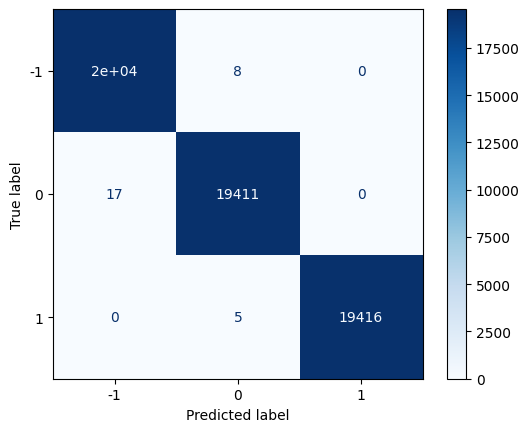

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
class_labels = ['-1', '0', '1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [19]:
#Precisão, Recall e F1-Score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precisão: {precision:.10f}')
print(f'Recall: {recall:.10f}')
print(f'F1-score: {f1:.10f}')

Precisão: 0.9994865125
Recall: 0.9994864245
F1-score: 0.9994864417


In [20]:
#validação cruzada (k-fold com k=5)
scores = cross_val_score(best_clf, X_resampled, y_resampled, cv=5)

print("Pontuações da validação cruzada:", scores)

Pontuações da validação cruzada: [0.79970075 0.92398517 0.94753362 0.96944069 0.89612438]


In [21]:
#média e o desvio padrão das pontuações da validação cruzada
print(f'Média das pontuações: {scores.mean():.10f}')
print(f'Desvio padrão das pontuações: {scores.std():.10f}')

Média das pontuações: 0.9073569252
Desvio padrão das pontuações: 0.0590949764


In [22]:
#Previsões com base nos valores de entrada
def predict_ac_status():
    outside_temp = float(entry_outside_temp.get())
    temp_103 = float(entry_temp_103.get())
    humidity_103 = float(entry_humidity_103.get())
    heat_index_103 = float(entry_heat_index_103.get())
    occupation = float(entry_occupation.get())

    #Previsão com base nos valores inseridos
    prediction = best_clf.predict([[outside_temp, temp_103, humidity_103, heat_index_103, occupation]])

    # Controlar o resultado para "Ligar AC em quente", "Ligar AC em frio" ou "desligar o AC"
    if prediction[0] == -1:
        result_label.config(text="Ligar AC em quente")
    elif prediction[0] == 1:
        result_label.config(text="Ligar AC em frio")
    else:
        result_label.config(text="Desligar o AC")

In [23]:
#Interface
root = tk.Tk()
root.title("Sistema de Controlo do AC")

frame = tk.Frame(root)
frame.pack(padx=20, pady=20)

#Entrada dados
entry_outside_temp = tk.Entry(frame, width=10, justify='center')
entry_temp_103 = tk.Entry(frame, width=10, justify='center')
entry_humidity_103 = tk.Entry(frame, width=10, justify='center')
entry_heat_index_103 = tk.Entry(frame, width=10, justify='center')
entry_occupation = tk.Entry(frame, width=10, justify='center')

entry_outside_temp.grid(row=0, column=1)
entry_temp_103.grid(row=1, column=1)
entry_humidity_103.grid(row=2, column=1)
entry_heat_index_103.grid(row=3, column=1)
entry_occupation.grid(row=4, column=1)

#Título das variáveis
tk.Label(frame, text="Outside Temperature (x10)(ºC)").grid(row=0, column=0)
tk.Label(frame, text="Temperature 103 (x10)(ºC)").grid(row=1, column=0)
tk.Label(frame, text="Humidity (x10)(%)").grid(row=2, column=0)
tk.Label(frame, text="Heat Index 103 (x10)(ºC)").grid(row=3, column=0)
tk.Label(frame, text="Occupation").grid(row=4, column=0)

#Botão 'Prever'
predict_button = tk.Button(frame, text="Prever", command=predict_ac_status)
predict_button.grid(row=5, columnspan=2)

#Resultado
result_label = tk.Label(frame, text="")
result_label.grid(row=6, columnspan=2)

root.mainloop()